# Overview on reflax

## Imports

In [ ]:
# ==== GPU selection ====
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# =======================

# NOTE: without 64-bit precision,
# the Cholesky decomposition used
# in sampling thickness profiles
# will fail, apart from that single
# precision is sufficient
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from flax import nnx

import matplotlib.pyplot as plt

# simulator setup
from reflax._reflectance_models._one_layer_model import get_polarization_components
from reflax.parameter_classes.parameters import (
    ForwardModelParams,
    LayerParams,
    SetupParams,
    LightSourceParams,
    TransmissionMediumParams,
    IncidentMediumParams
)

# constants
from reflax import (
    ONE_LAYER_MODEL,
    TRANSFER_MATRIX_METHOD,
    S_POLARIZED,
    NO_NORMALIZATION,
    MIN_MAX_NORMALIZATION
)

# thickness sampling
from reflax.thickness_modeling.function_sampling import (
    sample_derivative_bound_gp,
    sample_linear_functions
)

# forward modeling
from reflax.forward_model.forward_model import forward_model
from reflax.forward_model.forward_model import batched_forward_model

# neural operator initialization
from reflax.thickness_modeling.operator_learning import (
    NeuralOperatorMLP,
    save_model,
    load_model,
    train_neural_operator
)

# optimization through the differentiable simulator
from reflax.thickness_modeling.nn_modeling import (
    RawGrowthNN,
    predict_growth_rate,
    predict_thickness,
    pretrained_initialization,
    train_nn_model
)

## Forward modeling: thickness time series → reflectance time series

### Setting up the forward model

In [3]:
model = ONE_LAYER_MODEL # alternatively: TRANSFER_MATRIX_METHOD

# here we will normalize the reflectance
# to lie between -1 and 1
normalization = MIN_MAX_NORMALIZATION

# wavelength of the light source in nm
wavelength = 632.8

# angle of incidence to the surface normal
polar_angle = jnp.deg2rad(75)
azimuthal_angle = jnp.deg2rad(0)

# setup parameters
setup_params = SetupParams(
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle,
)

# polarization state of the light source
polarization_state = S_POLARIZED
s_component, p_component = get_polarization_components(polarization_state)

# setting up the light source parameters
light_source_params = LightSourceParams(
    wavelength = wavelength,
    s_component = s_component,
    p_component = p_component
)

# optical parameters of the incident medium
# typically air
permeability_reflection = 1.0
permittivity_reflection = 1.0
incident_medium_params = IncidentMediumParams(
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection
)

# optical parameters of the transmission medium
# a.k.a. the substrate on which 
# the thin film is deposited
permeability_transmission = 1.0
permittivity_transmission = (3.8827 + 0.019626j)**2
transmission_medium_params = TransmissionMediumParams(
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission
)

backside_mode = 1

# possibly static layers below the growing thin film
static_layer_params = LayerParams(
    thicknesses = jnp.array([0.0]),
    permeabilities = jnp.array([1.0]),
    permittivities = jnp.array([1.457**2]),
)

# optical parameters of the growing thin film
n_variable = 1.457
k_variable = 0.0
permeability_variable_layer = 1.0
permittivity_variable_layer = (n_variable + 1j * k_variable)**2
variable_layer_params = LayerParams(
    permeabilities = permeability_variable_layer,
    permittivities = permittivity_variable_layer,
)

# setting up the forward model parameters
forward_model_params = ForwardModelParams(
    model = model,
    setup_params = setup_params,
    light_source_params = light_source_params,
    incident_medium_params = incident_medium_params,
    transmission_medium_params = transmission_medium_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    backside_mode = backside_mode,
    polarization_state = polarization_state,
    normalization = normalization,
)


### Generating an examplary thickness time series

We use the sampling tools for smooth non-decreasing functions also implemented in `reflax`.

In [4]:
# as an example we take 400 time points
# between 0 and one hour
time_points_measured = jnp.linspace(0, 1, 400)

# specify the random key
random_key = jax.random.PRNGKey(89)

# here we only want to sample one
# thickness profile
num_samples = 1

# parameters of the RBF kernel of the
# underlying Gaussian process
lengthscale = 0.1
variance = 10.0

# minimum and maximum growth 
# rate in nm/h (per hour
# as of the definition of
# time_points)
min_slope = 200.0
max_slope = 1800.0

# minimum and maximum final thickness
min_final_thickness = 800.0
max_final_thickness = 1200.0

# draw the sample
true_thickness, true_growth_rate = sample_derivative_bound_gp(
    random_key,
    num_samples,
    time_points_measured,
    lengthscale,
    variance,
    min_slope,
    max_slope,
    random_final_values = True,
    min_final_value = min_final_thickness,
    max_final_value = max_final_thickness,
    convex_samples = True,
)

# squeeze the output, as it is generate with
# shape num_samples x num_time_steps
true_thickness = jnp.squeeze(true_thickness)
true_growth_rate = jnp.squeeze(true_growth_rate)

### Running the forward model

If we want to model static sublayers, we must use the `TRANSFER_MATRIX_METHOD`, if we only want to model the growing thin film, we can use either the `TRANSFER_MATRIX_METHOD` or the `ONE_LAYER_MODEL` for the model variable.

In [5]:
measured_reflectance = forward_model(
    model = model,
    setup_params = setup_params,
    light_source_params = light_source_params,
    incident_medium_params = incident_medium_params,
    transmission_medium_params = transmission_medium_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = true_thickness,
    backside_mode = backside_mode,
    polarization_state = polarization_state,
    normalization = normalization
)

### Plotting

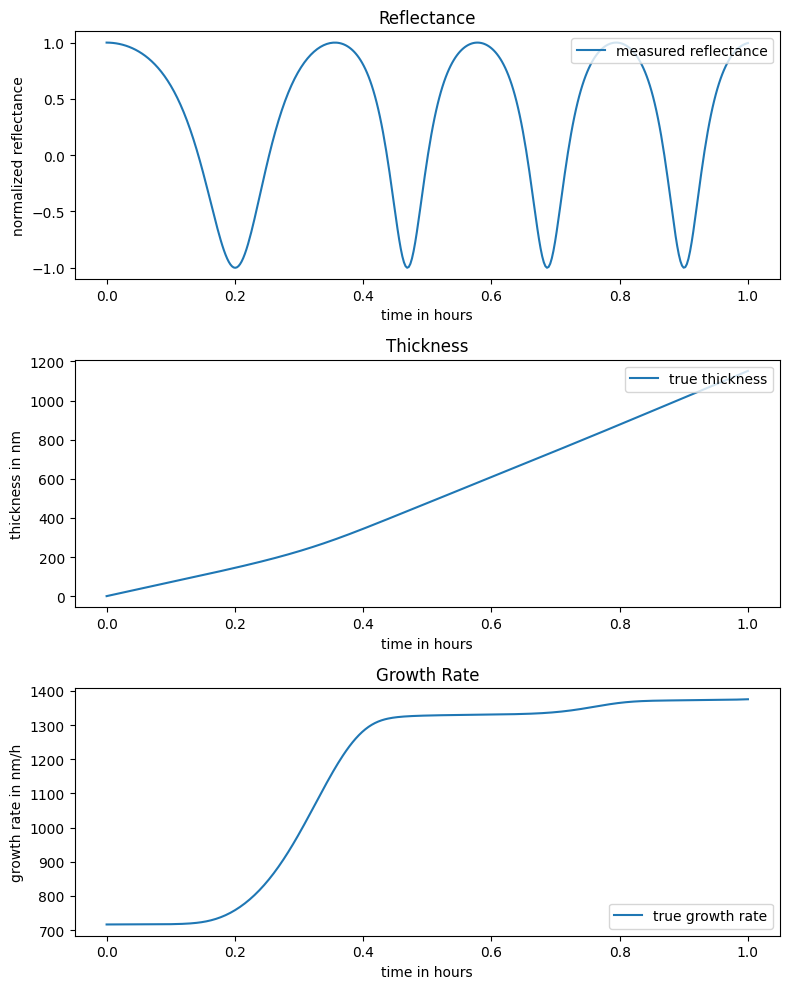

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

# plot true reflectance in the first subplot
ax1.plot(time_points_measured, measured_reflectance, label = "measured reflectance")
ax1.set_xlabel("time in hours")
ax1.set_ylabel("normalized reflectance")
ax1.legend(loc = "upper right")
ax1.set_title("Reflectance")

# plot thickness sample in the second subplot
ax2.plot(time_points_measured, true_thickness, label = "true thickness")
ax2.set_xlabel("time in hours")
ax2.set_ylabel("thickness in nm")
ax2.legend(loc = "upper right")
ax2.set_title("Thickness")

# plot derivative in the third subplot
ax3.plot(time_points_measured, true_growth_rate, label = "true growth rate")
ax3.set_xlabel("time in hours")
ax3.set_ylabel("growth rate in nm/h")
ax3.legend(loc = "lower right")
ax3.set_title("Growth Rate")

plt.tight_layout()
plt.savefig("ground_truth.svg")

## Inverse modeling: reflectance time series → thickness time series

### Training a neural operator for inferring the thickness time series

#### Generating the training data

We first generate the training data. The training data is sampled at fixed time points, here $100$ equally spaced points between $0$ and $1$ hour. Measurements will typically have a higher temporal resolution, so we will need to downsample.

In [7]:
# path where the training data will be saved
training_data_path = "training_data.npz"

# equally spaced time points
num_eval_points_neural_operator = 100
time_points_neural_operator = jnp.linspace(0, 1, num_eval_points_neural_operator)

# simple linear thickness profiles
num_samples_linear = 100

# smooth thickness profiles, sampled
# based on a Gaussian process
num_samples_gp = 2000

# minimum and maximum final thickness
# for both linear and GP samples
# (in nm)
max_final_thickness = 1200.0
min_final_thickness = 800.0

# random keys for sampling
random_key_linear = jax.random.PRNGKey(123)
random_key_gp = jax.random.PRNGKey(89)

# sample linear functions
thicknesses_linear, derivatives_linear = sample_linear_functions(
    random_key_linear,
    num_samples_linear,
    time_points_neural_operator,
    min_final_thickness,
    max_final_thickness,
)

# parameters of the RBF kernel of the
# underlying Gaussian process
lengthscale_gp = 0.4
variance = 15.0

# minimum and maximum growth rate
# in nm/h (per hour), held via
# rejection sampling
min_slope = 200.0
max_slope = 1800.0

# draw the gp samples
thickness_gp, derivatives_gp = sample_derivative_bound_gp(
    random_key_gp,
    num_samples_gp,
    time_points_neural_operator,
    lengthscale_gp,
    variance,
    min_slope,
    max_slope,
    random_final_values = True,
    min_final_value = min_final_thickness,
    max_final_value = max_final_thickness,
    convex_samples = True, # we limit ourselves to convex thickness profiles
)

# concatenate all thicknesses (linear and GP) and derivatives
thicknesses_training_neural_operator = jnp.concatenate((thicknesses_linear, thickness_gp), axis=0)
derivatives_training_neural_operator = jnp.concatenate((derivatives_linear, derivatives_gp), axis=0)

# generate reflectance data
reflectances = batched_forward_model(
    model = model,
    setup_params = setup_params,
    light_source_params = light_source_params,
    incident_medium_params = incident_medium_params,
    transmission_medium_params = transmission_medium_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = thicknesses_training_neural_operator,
    backside_mode = backside_mode,
    polarization_state = polarization_state,
    normalization = normalization,
    computation_batch_size = 100
)

# save the training data
jnp.savez(
    training_data_path,
    thicknesses = thicknesses_training_neural_operator,
    derivatives = derivatives_training_neural_operator,
    reflectances = reflectances,
    time_points = time_points_neural_operator,
)

#### Training the neural operator

With this training data, we can train the neural operator.

In [8]:
neural_operator_path = "neural_operator.pickle"

# load the training data
training_data = jnp.load(training_data_path)
reflectances_training_neural_operator = training_data["reflectances"]
thicknesses_training_neural_operator = training_data["thicknesses"]
derivatives_training_neural_operator = training_data["derivatives"]
time_points_training_neural_operator = training_data["time_points"]

neural_operator = NeuralOperatorMLP(
    hidden_dims = [512, 512],
    num_eval_points = time_points_neural_operator.shape[0],
    rngs = nnx.Rngs(42),
)

neural_operator = train_neural_operator(
    model = neural_operator,
    reflectance_data = reflectances_training_neural_operator,
    thickness_data = thicknesses_training_neural_operator,
    learning_rate = 1e-4,
    test_set_size = 0.2,
    num_epochs = 20000,
    print_interval = 500,
    patience = 4000,
    random_seed_split = 42 
)

save_model(
    neural_operator,
    filepath = neural_operator_path,
)

Starting training for 20000 epochs...
Train data: 1680 samples, Validation data: 420 samples.
Validation & logging every 500 epochs. Early stopping patience: 4000 checks.
Epoch 500/20000 | Train Loss: 3658.934746 | Val Loss: 3725.533885
Epoch 1000/20000 | Train Loss: 2009.134937 | Val Loss: 2152.310215
Epoch 1500/20000 | Train Loss: 1228.095306 | Val Loss: 1309.045383
Epoch 2000/20000 | Train Loss: 722.721512 | Val Loss: 762.650064
Epoch 2500/20000 | Train Loss: 460.392678 | Val Loss: 476.226596
Epoch 3000/20000 | Train Loss: 340.999867 | Val Loss: 352.154407
Epoch 3500/20000 | Train Loss: 267.673184 | Val Loss: 281.297548
Epoch 4000/20000 | Train Loss: 210.689904 | Val Loss: 227.373683
Epoch 4500/20000 | Train Loss: 164.283606 | Val Loss: 183.919974
Epoch 5000/20000 | Train Loss: 120.190692 | Val Loss: 141.564185
Epoch 5500/20000 | Train Loss: 84.779554 | Val Loss: 105.855715
Epoch 6000/20000 | Train Loss: 59.000300 | Val Loss: 78.188095
Epoch 6500/20000 | Train Loss: 40.866385 | Val 

#### Testing the neural operator

Let us test the neural operator on the example thickness time series generated above (which has a shorter lengh scale in the RBF Kernel compared to the training data).

In [9]:
# load the neural operator model
neural_operator = load_model(
    filepath = neural_operator_path,
    abstract_model = neural_operator,
)
# downsample the time points to the number of points in the neural operator
indices = jnp.linspace(0, time_points_measured.shape[0] - 1, num_eval_points_neural_operator).astype(int)
downsampled_time_points = time_points_measured[indices]
measured_reflectance_downsampled = measured_reflectance[indices]
thickness_neural_operator = neural_operator(measured_reflectance_downsampled)
growth_rate_neural_operator = jnp.gradient(thickness_neural_operator, downsampled_time_points)
optimization_result_reflectance_neural_operator = forward_model(
    model = model,
    setup_params = setup_params,
    light_source_params = light_source_params,
    incident_medium_params = incident_medium_params,
    transmission_medium_params = transmission_medium_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = thickness_neural_operator,
    backside_mode = backside_mode,
    polarization_state = polarization_state,
    normalization = normalization
)

#### Plotting the results

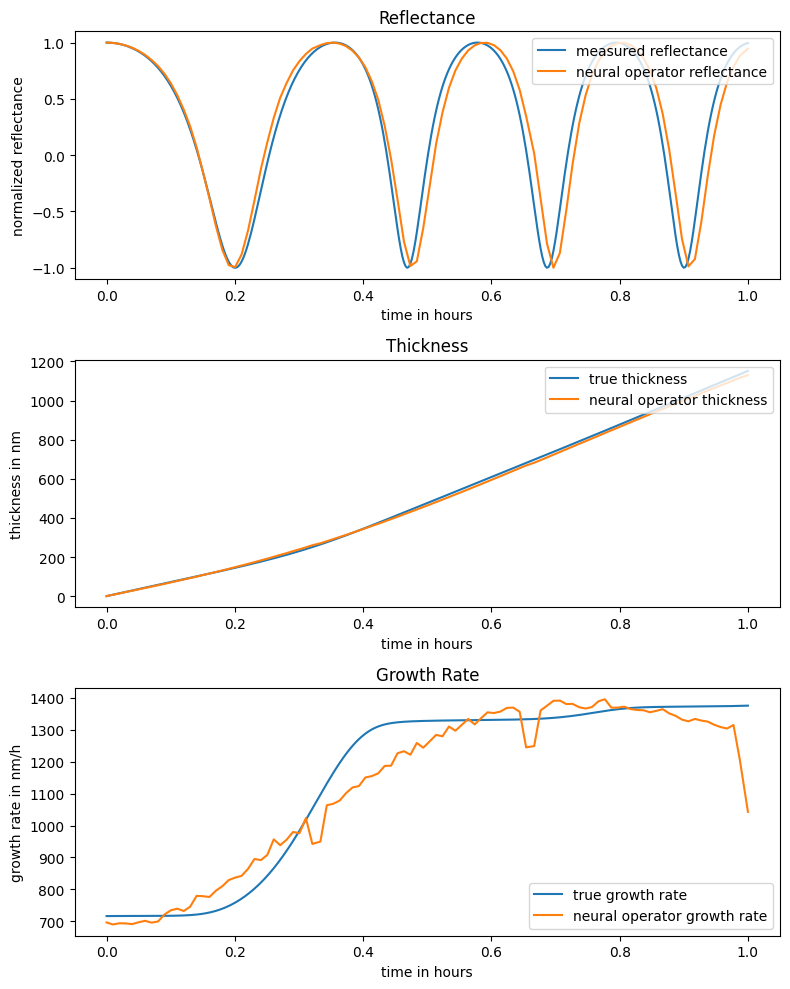

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

# plot true reflectance in the first subplot
ax1.plot(time_points_measured, measured_reflectance, label = "measured reflectance")
ax1.plot(downsampled_time_points, optimization_result_reflectance_neural_operator, label = "neural operator reflectance")
ax1.set_xlabel("time in hours")
ax1.set_ylabel("normalized reflectance")
ax1.legend(loc = "upper right")
ax1.set_title("Reflectance")

# plot thickness sample in the second subplot
ax2.plot(time_points_measured, true_thickness, label = "true thickness")
ax2.plot(downsampled_time_points, thickness_neural_operator, label = "neural operator thickness")
ax2.set_xlabel("time in hours")
ax2.set_ylabel("thickness in nm")
ax2.legend(loc = "upper right")
ax2.set_title("Thickness")

# plot derivative in the third subplot
ax3.plot(time_points_measured, true_growth_rate, label = "true growth rate")
ax3.plot(downsampled_time_points, growth_rate_neural_operator, label = "neural operator growth rate")
ax3.set_xlabel("time in hours")
ax3.set_ylabel("growth rate in nm/h")
ax3.legend(loc = "lower right")
ax3.set_title("Growth Rate")

plt.tight_layout()
plt.savefig("neural_operator_results.svg")

### Inferring the thickness time series by optimization through the differentiable simulator

We will use the differentiability of our simulator to infer the thickness profile represented by a neural network (more exactly, the neural network represents a raw growth rate which is made positive (softplus) and numerically integrated to yield a monotonically increasing thickness profile). We will use *neural operator initialized optimization* here, i.e. we warm start the optimization to the neural operator result obtained above.

In [11]:
learning_rate = 4e-4
num_epochs = 25000
print_interval = 500
patience = 8000
seed_for_random_initialization = 0
pretrain_learning_rate = 4e-4
pretrain_num_epochs = 20000

growth_nn = RawGrowthNN(dmid = 1024, rngs = nnx.Rngs(42))

neural_operator = load_model(
    filepath = neural_operator_path,
    abstract_model = neural_operator,
)

growth_nn = pretrained_initialization(
    growth_nn,
    thickness_neural_operator,
    downsampled_time_points,
    pretrain_num_epochs,
    pretrain_learning_rate,
)

# train the neural network on the generated data
growth_nn, reflectance_losses = train_nn_model(
    growth_nn,
    forward_model_params,
    time_points_measured,
    measured_reflectance,
    learning_rate = learning_rate,
    num_epochs = num_epochs,
    print_interval = print_interval,
    patience = patience
)

# predict the thickness and derivative
optimization_result_thickness = predict_thickness(
    growth_nn,
    time_points_measured
)

optimization_result_growth_rate = predict_growth_rate(
    growth_nn,
    time_points_measured
)

# calculate the reflectance from the optimization_result thickness
optimization_result_reflectance = forward_model(
    model = model,
    setup_params = setup_params,
    light_source_params = light_source_params,
    incident_medium_params = incident_medium_params,
    transmission_medium_params = transmission_medium_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = optimization_result_thickness,
    backside_mode = backside_mode,
    polarization_state = polarization_state,
    normalization = normalization
)

👷 pre-training neural network...
🚀 New best! Pre-train Epoch 0/20000, Loss: 8.0459e+04
🚀 New best! Pre-train Epoch 200/20000, Loss: 1.4640e+02
🚀 New best! Pre-train Epoch 400/20000, Loss: 1.3973e+02
🚀 New best! Pre-train Epoch 600/20000, Loss: 1.2121e+02
🚀 New best! Pre-train Epoch 800/20000, Loss: 6.4849e+01
Pre-train Epoch 1000/20000, Current Loss: 2.8843e+01 (Best: 2.5203e+01)
Pre-train Epoch 1200/20000, Current Loss: 5.5529e+01 (Best: 1.2075e+01)
Pre-train Epoch 1400/20000, Current Loss: 2.0285e+01 (Best: 1.0586e+01)
Pre-train Epoch 1600/20000, Current Loss: 3.6767e+01 (Best: 1.0586e+01)
🚀 New best! Pre-train Epoch 1800/20000, Loss: 9.2731e+00
🚀 New best! Pre-train Epoch 2000/20000, Loss: 7.2826e+00
Pre-train Epoch 2200/20000, Current Loss: 1.1266e+02 (Best: 6.0532e+00)
Pre-train Epoch 2400/20000, Current Loss: 3.1966e+02 (Best: 5.1741e+00)
Pre-train Epoch 2600/20000, Current Loss: 1.5122e+01 (Best: 4.4063e+00)
Pre-train Epoch 2800/20000, Current Loss: 4.3767e+00 (Best: 4.0095e+00)

#### Plotting the results

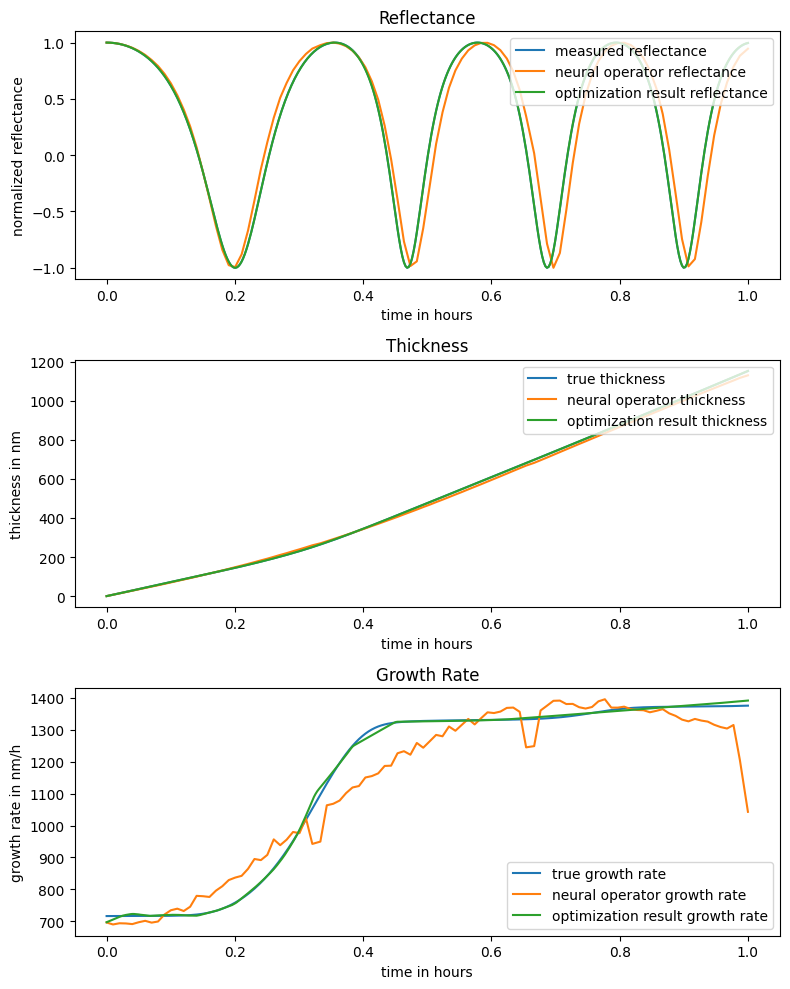

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

# plot true reflectance in the first subplot
ax1.plot(time_points_measured, measured_reflectance, label = "measured reflectance")
ax1.plot(downsampled_time_points, optimization_result_reflectance_neural_operator, label = "neural operator reflectance")
ax1.plot(time_points_measured, optimization_result_reflectance, label = "optimization result reflectance")
ax1.set_xlabel("time in hours")
ax1.set_ylabel("normalized reflectance")
ax1.legend(loc = "upper right")
ax1.set_title("Reflectance")

# plot thickness sample in the second subplot
ax2.plot(time_points_measured, true_thickness, label = "true thickness")
ax2.plot(downsampled_time_points, thickness_neural_operator, label = "neural operator thickness")
ax2.plot(time_points_measured, optimization_result_thickness, label = "optimization result thickness")
ax2.set_xlabel("time in hours")
ax2.set_ylabel("thickness in nm")
ax2.legend(loc = "upper right")
ax2.set_title("Thickness")

# plot derivative in the third subplot
ax3.plot(time_points_measured, true_growth_rate, label = "true growth rate")
ax3.plot(downsampled_time_points, growth_rate_neural_operator, label = "neural operator growth rate")
ax3.plot(time_points_measured, optimization_result_growth_rate, label = "optimization result growth rate")
ax3.set_xlabel("time in hours")
ax3.set_ylabel("growth rate in nm/h")
ax3.legend(loc = "lower right")
ax3.set_title("Growth Rate")

plt.tight_layout()
plt.savefig("optimization_results.svg")